In [255]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.inspection import permutation_importance

In [275]:
'''
This function cleans the raw dataframe created from the file on disk
    - It drops columns that do not provide a signal
    - there are some inf values in some columns
    - converts the Label (target) column to binary (0 for BENIGN) 
'''
def clean_data(data_df):
    data_df.drop(['Source IP', 
              'Destination IP', 
              'SimillarHTTP', 
              'Flow ID', 
              'Timestamp', 
              'Unnamed: 0'], 
             axis=1, 
             inplace=True)
    
    # there are some inf values that we will impute with the max
    # values for that column
    data_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    for col in ['Flow Bytes/s', 'Flow Packets/s']:
        max_val = data_df[col].max()
        data_df[col] = data_df[col].fillna(max_val)

    # change label to int (0 or 1) from object (0 if BENIGN)
    data_df['Label'] = data_df['Label'].map(lambda x: 0 if x=='BENIGN' else 1)

In [251]:
# find the proportion of the target column to get an idea of the distribution

y.value_counts(normalize=True)

Label
1    0.814694
0    0.185306
Name: proportion, dtype: float64

In [252]:
'''
This function trains each estimator in the list of estimators
on the training data provided
'''

def train_estimators(estimators,
                    X_train, 
                    y_train):
    for i, estimator in enumerate(estimators):
        estimator.fit(X_train, y_train)        

In [276]:
'''
This function scores the trainied estimators on the test data
provided
returns lists of 
    - accuracy scores
    - roc/auc scores
    - precision scores
    - recall scores
'''
def score_estimators(trained_estimators,
                     X_test,
                     y_test):
    scores = []
    roc_auc_scores = []
    precision_scores = []
    recall_scores = []

    for i, estimator in enumerate(trained_estimators):
        scores.append(estimator.score(X_test, y_test))
        preds = estimator.predict(X_test)
        roc_auc_scores.append(roc_auc_score(y_test, preds))
        precision_scores.append(precision_score(y_test, preds))
        recall_scores.append(recall_score(y_test, preds))
        
    return scores, roc_auc_scores, precision_scores, recall_scores
    

In [277]:
'''
This function visualizes metrics given the trained estimaters
It displays for each estimator
    - Confusion Matrices
    - Roc Curve
    - Precision/Recall curve
'''
def display_metrics(trained_estimators, 
                    estimator_names, 
                    X_test, 
                    y_test):

    # display confusion matrices for each of the estimators
    fig, axes = plt.subplots((len(trained_estimators)//3) + 1, 3, figsize=(10,6))
    for i, estimator in enumerate(trained_estimators):
        row, col = i//3, i%3
        ConfusionMatrixDisplay.from_estimator(estimator,
                                              X_test,
                                              y_test,
                                              ax=axes[row, col])
        axes[row, col].set_title(estimator_names[i])
        
    for i in range(len(trained_estimators), (1 + (len(trained_estimators)//3)) * 3):
        axes[i//3, i%3].axis('off')

    plt.tight_layout()
    plt.show()

    # display Roc Curves and Precision Recall curves
    fig, axes = plt.subplots(1, 2, figsize=(10,6))
    for i, estimator in enumerate(trained_estimators):
        RocCurveDisplay.from_estimator(estimator,
                                       X_test,
                                       y_test,
                                       ax=axes[0])
        axes[0].set_title('ROC-AUC')
        
        PrecisionRecallDisplay.from_estimator(estimator,
                                              X_test,
                                              y_test,
                                              ax=axes[1])
        axes[1].set_title('Precision Recall')
        
    plt.tight_layout()
    plt.show()
        
    

In [278]:
'''
This function displays feature importance for each trained estimator
'''
def display_feature_importance(trained_estimators, 
                               X_test, 
                               y_test, 
                               estimator_names,
                               feature_names):

    for i, estimator in enumerate(trained_estimators):
        print(f'Estimator: {estimator_names[i]}:')
        print()
        
        r = permutation_importance(estimator, 
                                   X_test, 
                                   y_test,
                                   n_repeats=30,
                                   random_state=0)
        
        for i in r.importances_mean.argsort()[::-1]:
            if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
                print(f"{feature_names[i]:<30}"
                      f"{r.importances_mean[i]:.7f}"
                      f" +/- {r.importances_std[i]:.7f}")
        print()

In [279]:
'''
This function creates a dataframe given various scores
'''
def create_scores_df(estimator_names,
                     scores,
                     roc_auc_scores,
                     precision_scores,
                     recall_scores):
    scores_df = pd.DataFrame({'estimator': estimator_names,
                          'accuracy': scores,
                          'roc_auc': roc_auc_scores,
                          'precision': precision_scores,
                          'recall': recall_scores}).set_index('estimator')
    scores_df = scores_df.sort_values(by='accuracy', ascending=False)
    return scores_df

In [280]:
'''
This function plots the scores to compare the scores
for different estimators
'''
def display_scores(df):
    for column in df.columns:
        plt.plot(df.index, df[column], '-o')    
    plt.legend(df.columns)
    plt.ylim(min(df.min()), 1)
    plt.xticks(rotation=45)
    plt.ylabel('score (zoomed in)')
    plt.title('scores for classifiers')
    plt.tight_layout()
    plt.show()

In [281]:
'''
This function visualizes the results given dataframe and trained estimators 
'''
def visualize_results_df(test_df, 
                         trained_estimators, 
                         X_test_data=None, 
                         y_test_data=None):

    if X_test_data is None:
        clean_data(test_df)
        X_test_data, y_test_data = test_df.drop('Label', axis=1), test_df['Label']
        
    test_accuracy, test_auc_roc, test_precision, test_recall = score_estimators(trained_estimators,
                                                                                 X_test_data,
                                                                                 y_test_data)
    display_metrics(trained_estimators, estimator_names, X_test_data, y_test_data)
    test_scores_df = create_scores_df(estimator_names,
                                      test_accuracy,
                                      test_auc_roc,
                                      test_precision,
                                      test_recall)
    display(test_scores_df)
    display_scores(test_scores_df)

In [283]:
def visualize_results(testfile, trained_estimators):
    visualize_results_df(pd.read_csv(testfile, low_memory=False), trained_estimators)

In [284]:
ldap1_df = pd.read_csv('data/CICDDos2019/sampled_data/sampled_DrDoS_LDAP_1.csv', low_memory=False)
ldap2_df = pd.read_csv('data/CICDDos2019/sampled_data/sampled_DrDoS_LDAP_2.csv', low_memory=False)
ldap3_df = pd.read_csv('data/CICDDos2019/sampled_data/sampled_DrDoS_LDAP_3.csv', low_memory=False)
ldap_df = pd.concat([ldap1_df, ldap2_df, ldap3_df])
clean_data(ldap_df)

In [ ]:
ldap_df.info()

In [286]:
X, y = ldap_df.drop('Label', axis=1), ldap_df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((230145, 81), (230145,), (76715, 81), (76715,))

In [287]:
estimators = [Pipeline([('sclaler', StandardScaler()),
                       ('lgr', LogisticRegression(random_state=42))]),
              BaggingClassifier(random_state=42),
              RandomForestClassifier(random_state=42),
              AdaBoostClassifier(random_state=42),
              GradientBoostingClassifier(random_state=42)]

estimator_names = ['LogisticRegression',
                   'BaggingClassifier',
                   'RandomForestClassifier',
                   'AdaBoostClassifier',
                   'GrandienBoostingClassifier']

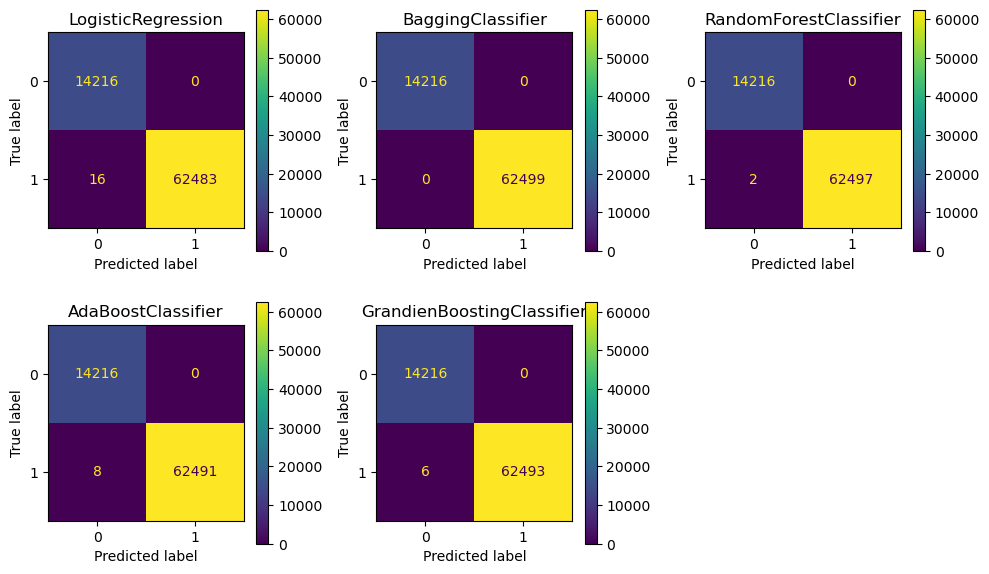

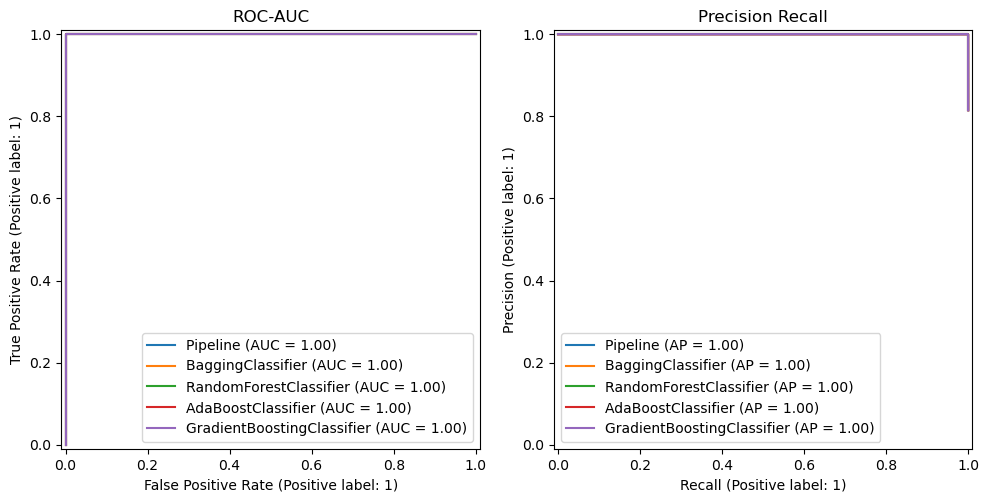

,accuracy,roc_auc,precision,recall
estimator,,,,
BaggingClassifier,1.000000,1.000000,1.0,1.000000
RandomForestClassifier,0.999974,0.999984,1.0,0.999968
GrandienBoostingClassifier,0.999922,0.999952,1.0,0.999904
AdaBoostClassifier,0.999896,0.999936,1.0,0.999872
LogisticRegression,0.999791,0.999872,1.0,0.999744


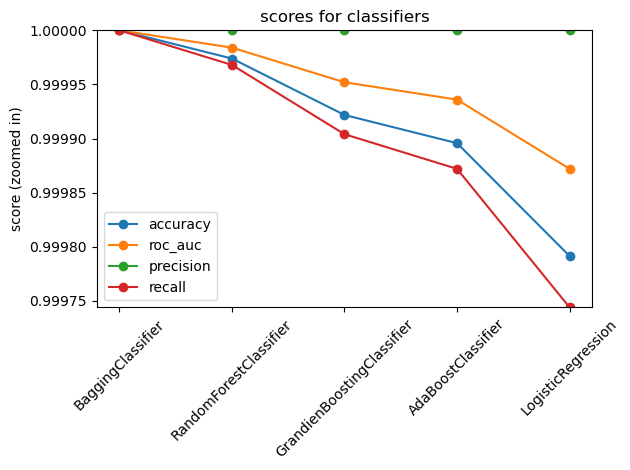

In [288]:
train_estimators(estimators, X_train, y_train)
visualize_results_df(ldap_df, estimators, X_test, y_test)

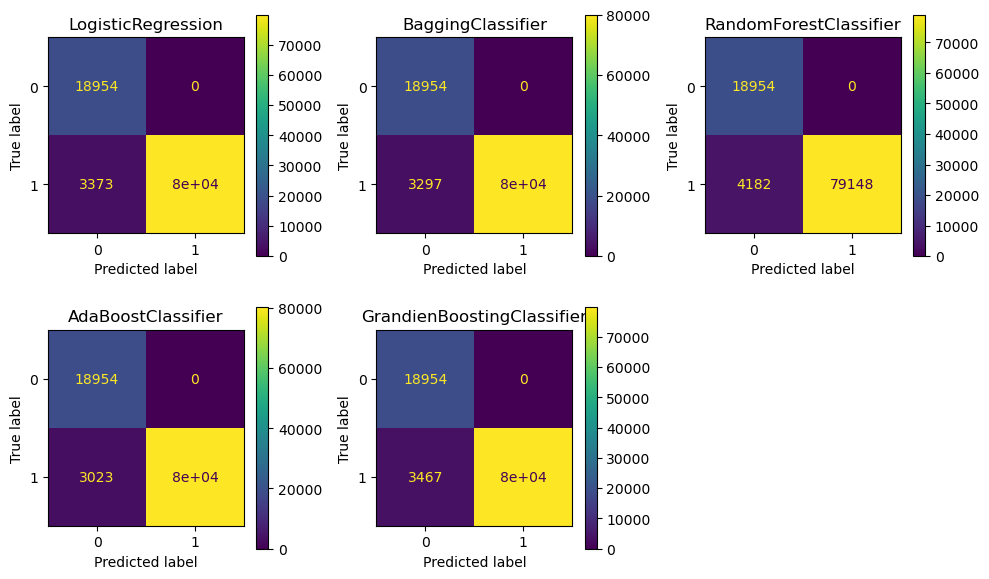

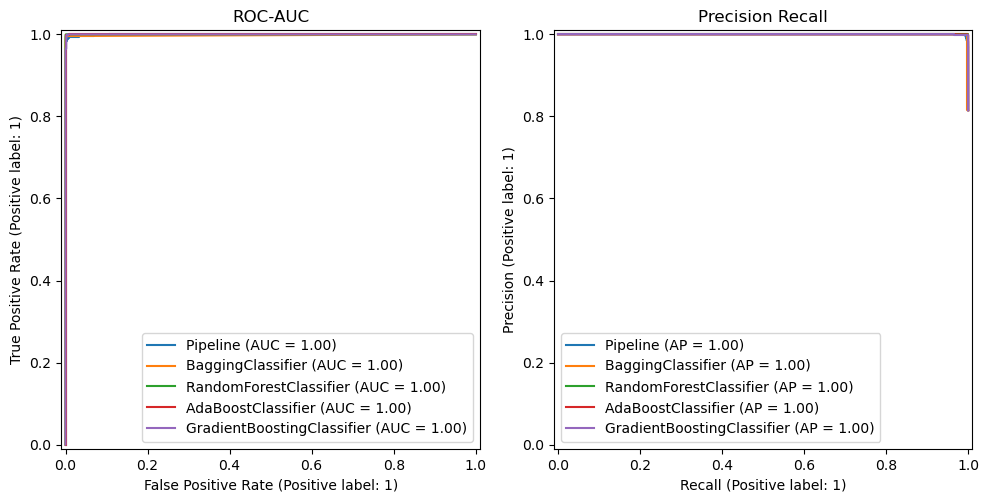

,accuracy,roc_auc,precision,recall
estimator,,,,
AdaBoostClassifier,0.970445,0.981861,1.0,0.963723
BaggingClassifier,0.967766,0.980217,1.0,0.960434
LogisticRegression,0.967023,0.979761,1.0,0.959522
GrandienBoostingClassifier,0.966104,0.979197,1.0,0.958394
RandomForestClassifier,0.959114,0.974907,1.0,0.949814


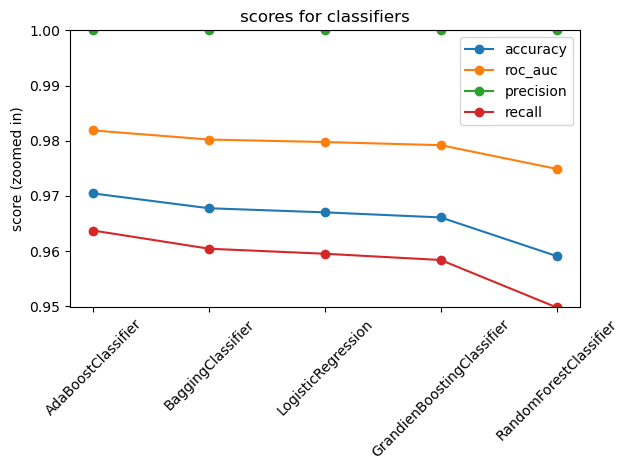

In [290]:
visualize_results('data/CICDDos2019/sampled_data/sampled_DrDoS_DNS_1.csv', estimators)

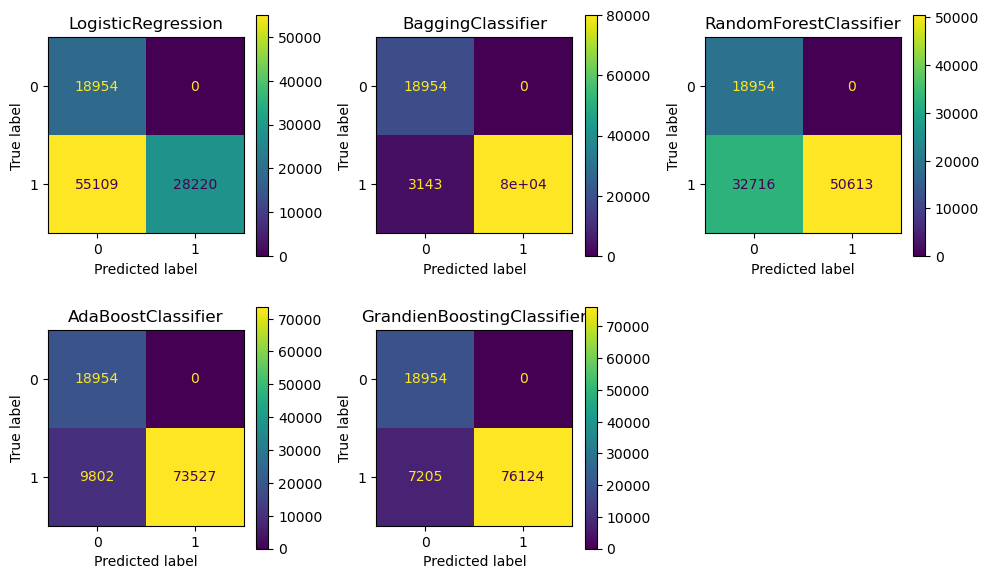

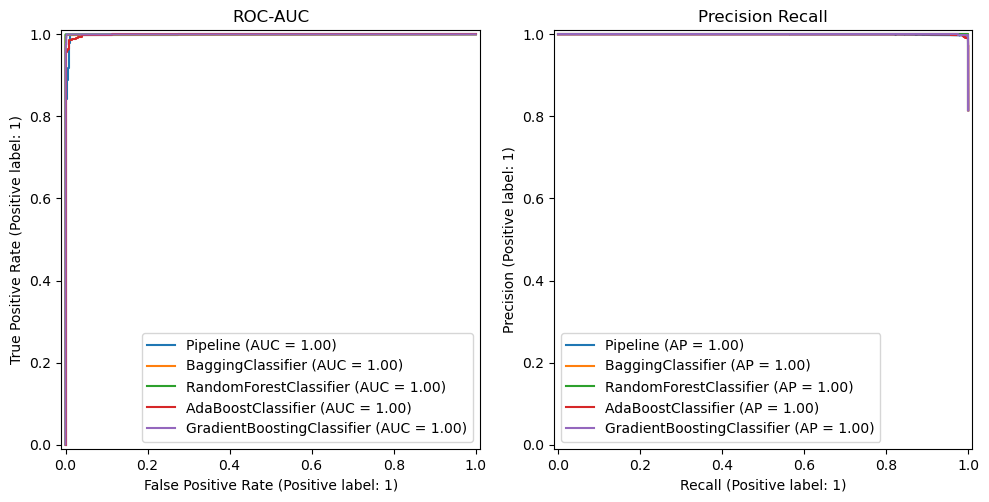

,accuracy,roc_auc,precision,recall
estimator,,,,
BaggingClassifier,0.969272,0.981141,1.0,0.962282
GrandienBoostingClassifier,0.929558,0.956768,1.0,0.913536
AdaBoostClassifier,0.904168,0.941185,1.0,0.882370
RandomForestClassifier,0.680142,0.803694,1.0,0.607388
LogisticRegression,0.461211,0.669329,1.0,0.338658


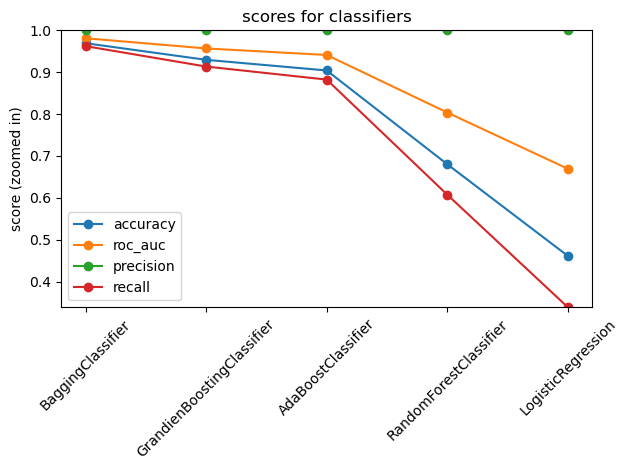

In [291]:
visualize_results('data/CICDDos2019/sampled_data/sampled_DrDoS_MSSQL_1.csv', estimators)